In [1]:
import sys

sys.path.append('/Users/dashiell/workspace/simplex-score-matching/src')

from ssm.simplex_proj import vector_simplex_proj
from ssm.visualize_simplex import rotate_simplex_to_xy
import ssm.aitchison as aitch

from sympy import symbols, exp, ln
from sympy.matrices import Matrix

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(45)


/Users/dashiell/miniconda3/envs/ssm/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [8]:
def softmax_jac2(x):
    _jvp = lambda s: jax.jvp(jax.nn.softmax, (x,), (s,))[1]
    return jax.vmap(_jvp)(jax.jacrev(jax.nn.softmax)(x))
x = jnp.array([2., 3., 4.])
jac = jax.jacobian(jax.nn.softmax)(x)
a1 = softmax_jac2(x)
a2 = jnp.matmul(jac, jac)
print(a1)
print(a2)

[[ 0.01078423  0.00387306 -0.01465728]
 [ 0.00387306  0.06115492 -0.06502797]
 [-0.01465728 -0.06502797  0.07968525]]
[[ 0.01078423  0.00387306 -0.01465728]
 [ 0.00387306  0.06115492 -0.06502797]
 [-0.01465728 -0.06502797  0.07968525]]


In [21]:
key, subkey = jax.random.split(key)
a3, grad_jac_sfm = jax.jvp(softmax_jac2, (jax.random.normal(subkey, (10,)),), (jnp.ones(10),))

In [22]:
grad_jac_sfm

DeviceArray([[-2.07498729e-09, -2.69043711e-11,  4.05697420e-11,
               1.07231513e-09, -8.47024395e-11,  1.67336034e-10,
               1.04305176e-10,  1.66722636e-09, -1.32668071e-10,
              -2.59473831e-11],
             [ 3.11890513e-11,  8.01678168e-13,  5.27077470e-12,
              -3.69157135e-11,  1.11684577e-11,  6.94590982e-11,
               3.17332827e-11, -5.50882950e-11,  9.74569904e-12,
              -1.86148926e-12],
             [ 1.54048607e-10,  3.34498900e-12, -9.41810865e-12,
              -5.50490209e-12,  3.25097501e-12,  2.20947843e-11,
               7.78195043e-12,  7.09942938e-11,  3.01942152e-12,
              -1.48825017e-13],
             [ 5.00354425e-10, -3.71497347e-11, -3.72819102e-11,
              -3.02228909e-10, -6.69434785e-11, -3.70746100e-10,
              -1.71717793e-10, -1.63279168e-10, -1.27034203e-10,
              -3.12435078e-11],
             [ 4.20247170e-11, -7.28356438e-12, -1.70177555e-12,
              -8.86729301e-

In [25]:
import jax.random as jrandom
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

def v(p):
    alpha = jnp.ones((p.shape[-1],))
    return -1. * (alpha * jnp.log(p)).sum()


def drift_potential(t, x, args):
    x = x / jnp.var(x, axis=-1, keepdims=True)
    p = jax.nn.softmax(x)
    alphas = jnp.ones((p.shape[-1],))
    num_alphas = alphas.sum()
    return -1 * aitch.simplex_metric_tensor_inv(
        p,
        (num_alphas * p) - alphas
    )


def diffusion(t, x, args):
    p = jax.nn.softmax(x)
    jac = jax.jacobian(jax.nn.softmax)(p)
    return 2 * jac
    
    



def do_sde(x0, num_steps, key):
    #ilr, ilr_inv = aitch.make_isometric_transforms(x.shape[-1])
    #x0 = ilr(x)
    min_noise, max_noise = 0.5, 5
    #key, *subkeys1 = jax.random.split(key, num_steps + 1)
    #key, *subkeys2 = jax.random.split(key, num_steps + 1)
    noise = jax.random.normal(key, (num_steps, x0.shape[-1]))
    # schedule = get_noise_schedule(min_noise, max_noise, num_steps)
    #noise = noise * schedule[...,None]
    alphas = jnp.ones((x0.shape[-1],))
    alpha_total = alphas.sum()
    payoff = make_payoff_matrix(alphas)
    delta_t = 1 / num_steps
    def sde_step(x, noise):
        # noise, sigma = noise_things
        g_inv = partial(aitch.simplex_metric_tensor_inv, jax.nn.softmax(x))
        scaled_noise = g_inv(noise)
        # new_inds = maybe_permute(key1, key2, x.shape[-1])
        drift = g_inv(jnp.matmul(payoff, alpha_total * x - alphas))
        #full_sigma = jnp.sqrt(delta_t) * noise
        new_x = x - (drift * delta_t) + (2 * jnp.sqrt(delta_t) * noise)
        return new_x, new_x
    final_loc, path = jax.lax.scan(
        sde_step,
        x0,
        noise
    )


In [3]:
from diffrax.term import _ControlTerm

class SimplexControlTerm(_ControlTerm):

    
    @staticmethod
    def prod(vf, control):
        _, g_inv = jax.jvp(
            jax.nn.softmax,
            (vf, ),
            (control, )
        )
        return g_inv
    

In [4]:
t0, t1 = 0, 6
#drift = lambda t, y, args: -y
diffusion = lambda t, y, args: y
brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-4, shape=(3,), key=jax.random.PRNGKey(0))
terms = MultiTerm(ODETerm(drift_potential), SimplexControlTerm(diffusion, brownian_motion))
solver = Euler()
saveat = SaveAt(dense=True)

sol = diffeqsolve(terms, solver, t0, t1, dt0=0.01, y0=aitch.clr(jnp.array([0.9, 0.3, 0.07])), saveat=saveat)


In [230]:
sol.evaluate(7.5)

DeviceArray([-4.185115 ,  1.917137 ,  2.2679775], dtype=float32, weak_type=True)

In [26]:
from diffrax import Heun

def run_sde(x0, t1, key):
    t0 = 0
    #diffusion = lambda t, y, args: y
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-4, shape=(3,), key=key)
    terms = MultiTerm(ODETerm(drift_potential), ControlTerm(diffusion, brownian_motion))
    solver = Heun()
    #saveat = SaveAt(ts=jnp.linspace(t0, t1, 50))
    sol = diffeqsolve(terms, solver, t0, t1, dt0=0.1, y0=aitch.clr(x0))
    return sol.ys[0]



keys = jnp.s tack(jax.random.split(key, 1000))
t1 = jnp.ones((1000,)) * 25

outs = jax.vmap(run_sde, in_axes=(None, 0, 0))(jnp.array([0.98, 0.013, 0.007]), t1, keys)


In [163]:
from functools import partial

a = jnp.array([ [[2., 3., 4.], [5., 6., 7.]], [[1., 2., 3.], [4., 5., 6.]]])
#a = jnp.array([[2., 3., 4.], [5., 6., 7.]])
v = jax.random.normal(key, a.shape)
sfm_a, partial_prod = jax.jvp(partial(jax.nn.softmax, axis=-1), (a,), (v,))
jax.vmap(jnp.tensordot)(v, partial_prod)

DeviceArray([0.829989 , 1.0401773], dtype=float32)

In [160]:
@jax.vmap
def hutch(x, v):
    _, partial_prod = jax.jvp(partial(jax.nn.softmax, axis=-1), (x,), (v,))
    return jnp.tensordot(v, partial_prod)

hutch(a, v)

DeviceArray([0.829989 , 1.0401773], dtype=float32)

DeviceArray([ 0.07571796,  0.13010478, -0.20582278], dtype=float32)

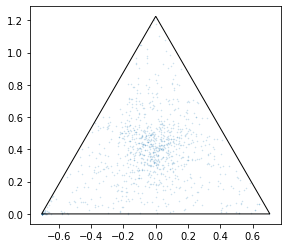

<Figure size 720x720 with 0 Axes>

In [27]:
sq32 = np.sqrt(3/2)
sq22 = np.sqrt(2)/2
triangle = np.array([[0, sq32], [-sq22, 0], [sq22, 0]])
#noised_samples = add_noise(0.8, 0.9, 3, 100_000, subkey) 

#samples = jax.random.dirichlet(subkey, jnp.array([0.1, 0.1, 0.1]), (100_000,))

plt.figure()

X = jax.vmap(rotate_simplex_to_xy)(jax.nn.softmax(outs))
plt.scatter(X[:,0], X[:,1], alpha=.2, s=.3)
t1 = plt.Polygon(triangle, fill=False)
plt.gca().add_patch(t1)
plt.gca().set_aspect('equal')
plt.figure(figsize=(10,10))
plt.show()

In [108]:
def hutch_estimator(x, key):
    v = jax.random.normal(key, (x.shape[0], ))
    return jnp.dot(jnp.matmul(v, x), v)

In [109]:
key, subkey = jax.random.split(key)
h = jnp.arange(10000).reshape((100,100)) / 10000
hutch_estimator(h, subkey)

DeviceArray(16.369148, dtype=float32)

In [106]:
jnp.dot(jnp.matmul(v, h), v)

DeviceArray(7.7647214, dtype=float32)

In [23]:
s = jnp.exp(b).sum()
print(jax.nn.softmax(b))
print(jnp.exp(b))
print(jnp.exp(b) / s)
print(jnp.log(jax.nn.softmax(b)))
print(b - jnp.log(s))
print(v(jax.nn.softmax(b)))
print(3 * jnp.log(jnp.exp(b).sum()))

[0.0242889  0.48785555 0.48785555]
[0.13533528 2.7182817  2.7182817 ]
[0.0242889  0.48785558 0.48785558]
[-3.717736  -0.7177359 -0.7177359]
[-3.7177358  -0.71773577 -0.71773577]
5.153208
5.1532073


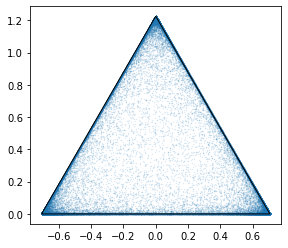

<Figure size 720x720 with 0 Axes>

In [8]:
key, subkey = jax.random.split(key)

sq32 = np.sqrt(3/2)
sq22 = np.sqrt(2)/2
triangle = np.array([[0, sq32], [-sq22, 0], [sq22, 0]])
#noised_samples = add_noise(0.8, 0.9, 3, 100_000, subkey) 

samples = jax.random.dirichlet(subkey, jnp.array([0.1, 0.1, 0.1]), (100_000,))

plt.figure()

X = jax.vmap(rotate_simplex_to_xy)(samples)
plt.scatter(X[:,0], X[:,1], alpha=.2, s=.1)
t1 = plt.Polygon(triangle, fill=False)
plt.gca().add_patch(t1)
plt.gca().set_aspect('equal')
plt.figure(figsize=(10,10))
plt.show()